In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv(r"C:\Users\irene\Desktop\DataAnalytics\Bootcamp\Simulacro empresarial\ProjecteData\Equip_19\Data\tourist_accommodation_10112025_clean.csv")

# Capping variables para eliminar outliers

In [12]:
df_sin_outliers = df.copy()
# 1. Definir las variables a procesar
variables_a_limitar = ['bathrooms', 'bedrooms', 'beds']

print("--- 📏 Aplicando Capping SOLO al Límite Superior por IQR (1.5) ---")

for columna in variables_a_limitar:
    print(f"\nProcesando columna: '{columna}'")
    
    # 2. Calcular Q1, Q3, e IQR
    Q1 = df_sin_outliers[columna].quantile(0.25)
    Q3 = df_sin_outliers[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # 3. Definir SOLO el Límite Superior
    limite_superior = Q3 + 1.5 * IQR
    
    # --- 4. Aplicar el Capping Superior ---
    
    # Identificar registros que superan el límite superior
    registros_sup = df_sin_outliers[columna] > limite_superior
    total_limitados = registros_sup.sum()
    
    # Acotar valores superiores
    df_sin_outliers[columna] = np.where(
        df_sin_outliers[columna] > limite_superior,
        limite_superior, # Si es mayor, sustituirlo por el límite superior
        df_sin_outliers[columna]
    )
    
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Límite Superior (Capping): {limite_superior:.2f}")
    print(f"  **Total de {columna} limitados: {total_limitados} (solo superiores)**")

print("\n--- ✅ Proceso de Capping completado, evitando la limitación inferior innecesaria. ---")

--- 📏 Aplicando Capping SOLO al Límite Superior por IQR (1.5) ---

Procesando columna: 'bathrooms'
  Q1: 1.00, Q3: 2.00, IQR: 1.00
  Límite Superior (Capping): 3.50
  **Total de bathrooms limitados: 357 (solo superiores)**

Procesando columna: 'bedrooms'
  Q1: 1.00, Q3: 3.00, IQR: 2.00
  Límite Superior (Capping): 6.00
  **Total de bedrooms limitados: 25 (solo superiores)**

Procesando columna: 'beds'
  Q1: 1.00, Q3: 4.00, IQR: 3.00
  Límite Superior (Capping): 8.50
  **Total de beds limitados: 161 (solo superiores)**

--- ✅ Proceso de Capping completado, evitando la limitación inferior innecesaria. ---


# Visualizaciones comparativas sin outliers

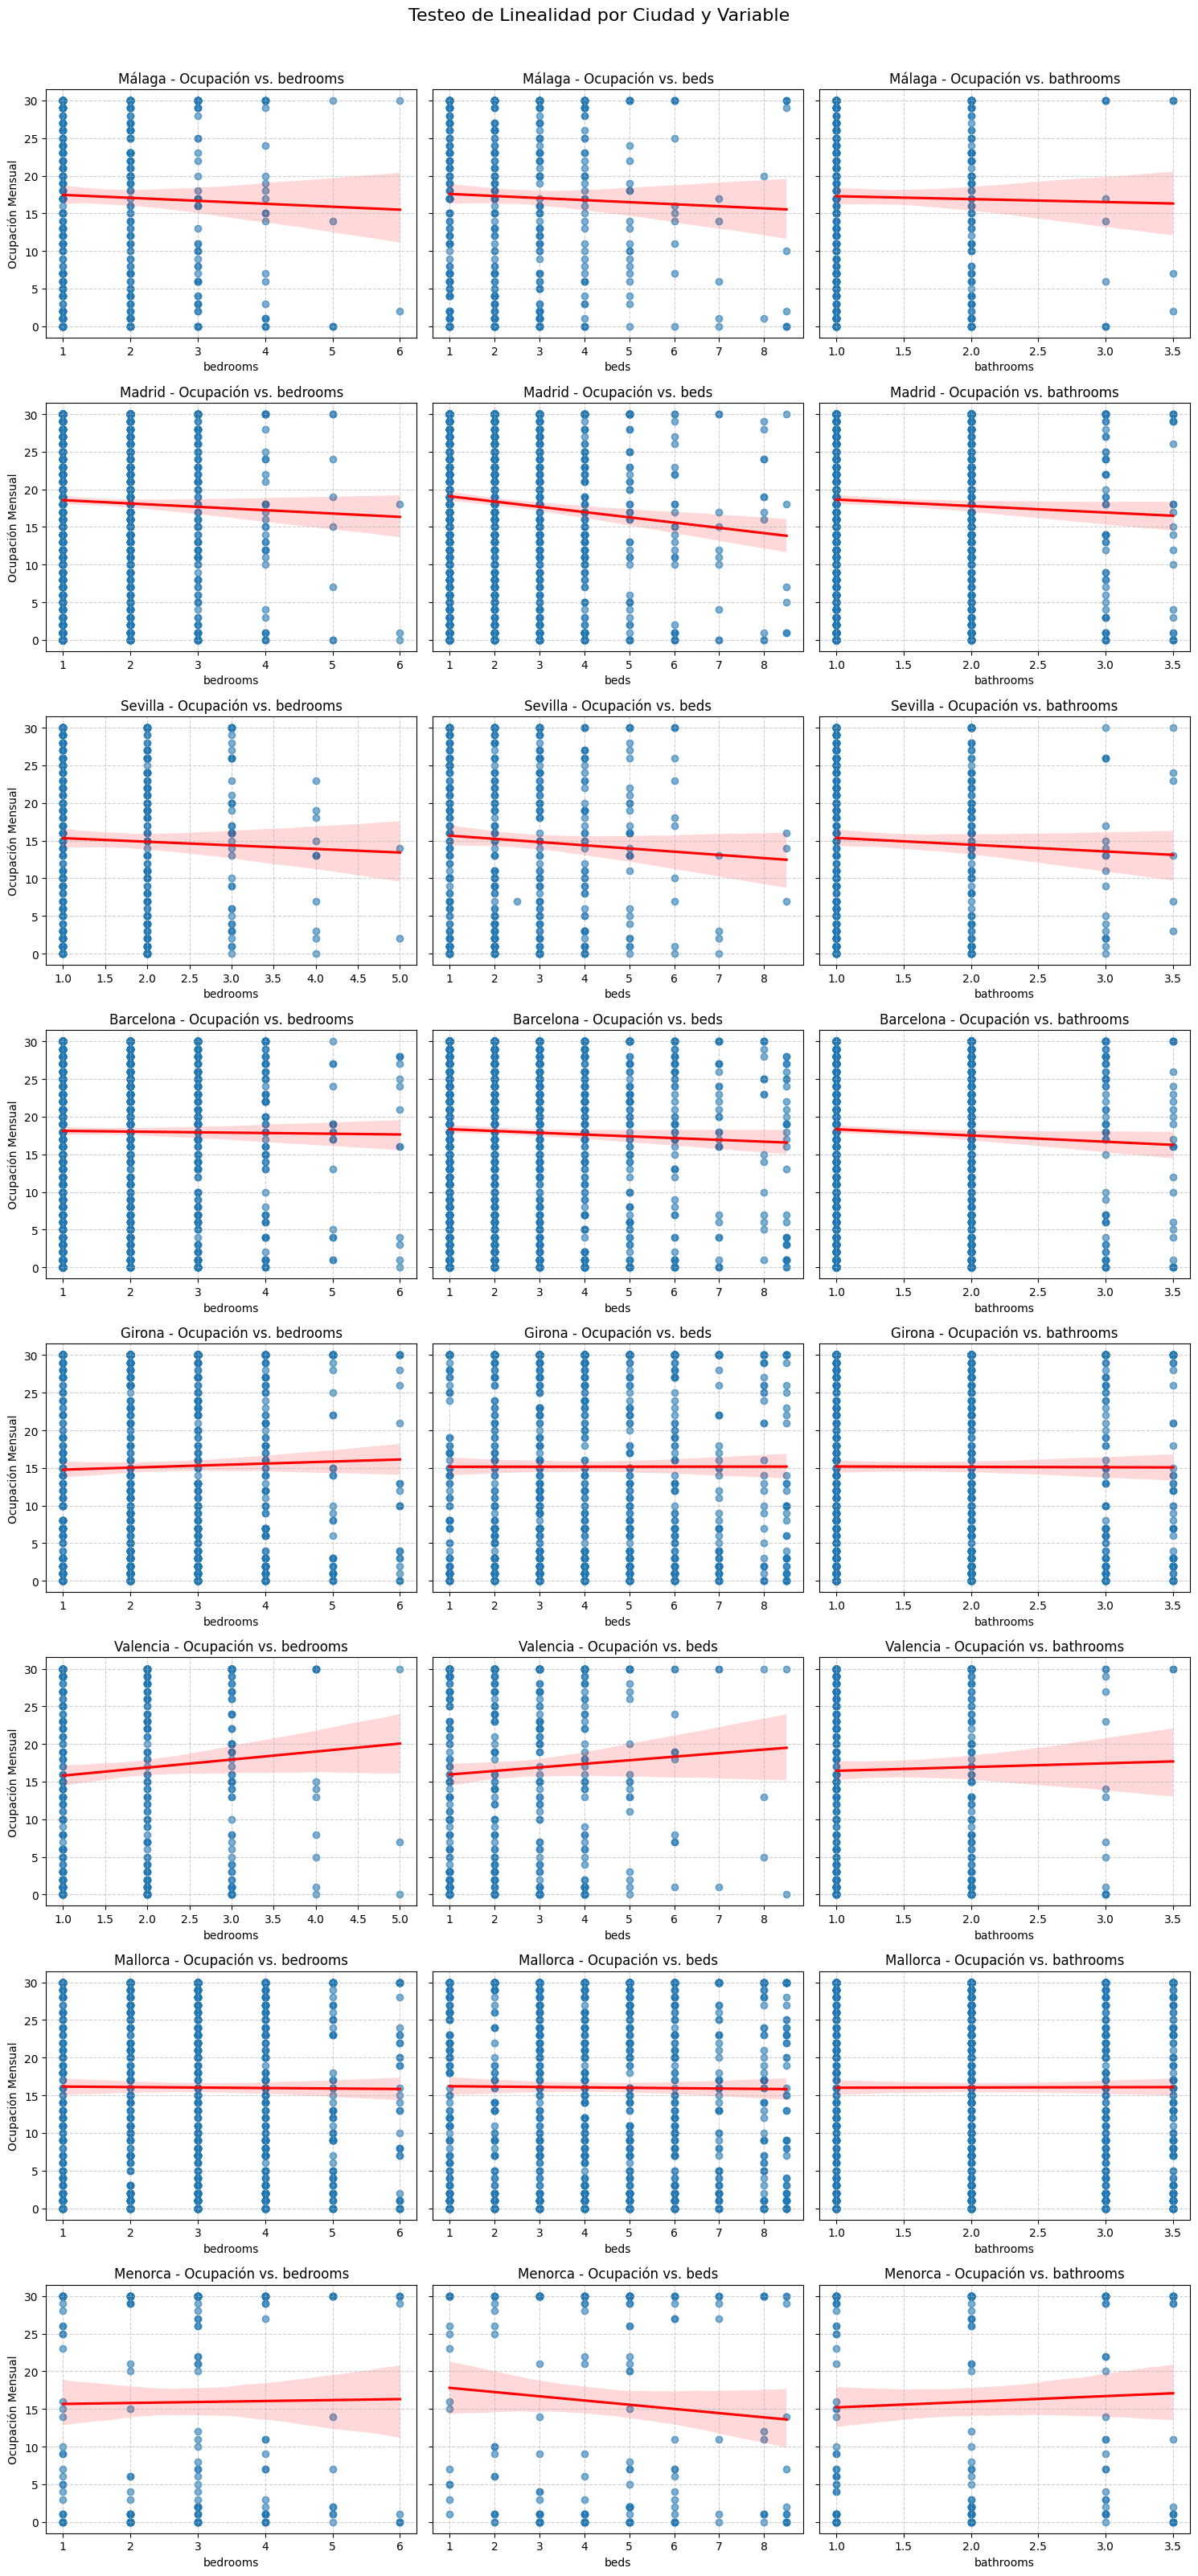

In [13]:
# Variables independientes a testear
variables_x = ['bedrooms', 'beds', 'bathrooms']
ciudades = df_sin_outliers['city'].unique()

# Definimos la rejilla: 
# Filas = Número de Ciudades
# Columnas = Número de variables_x
fig, axes = plt.subplots(len(ciudades), len(variables_x), 
                         figsize=(5 * len(variables_x), 4 * len(ciudades)), 
                         sharey=True) # Compartimos el eje Y para facilitar la comparación

# Iteramos sobre las ciudades (Filas)
for i, ciudad in enumerate(ciudades):
    df_ciudad = df_sin_outliers[df_sin_outliers['city'] == ciudad]
    
    # Iteramos sobre las variables X (Columnas)
    for j, x_var in enumerate(variables_x):
        # Seleccionamos el subplot actual
        ax = axes[i, j] 
        
        # Usamos regplot, pasándole el eje específico 'ax'
        sns.regplot(
            x=x_var, 
            y='ocupacion_mes',
            data=df_ciudad, 
            ax=ax,
            scatter_kws={'alpha': 0.6},
            line_kws={'color': 'red'}
        )
        
        # Título para cada gráfico
        ax.set_title(f'{ciudad} - Ocupación vs. {x_var}')
        ax.set_xlabel(x_var)
        ax.set_ylabel('Ocupación Mensual' if j == 0 else '') # Solo la primera columna tiene el label Y
        ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.suptitle('Testeo de Linealidad por Ciudad y Variable', fontsize=16, y=1.0)
# 
plt.show()

# Correlación enrte las variables independientes (matriz de corr)

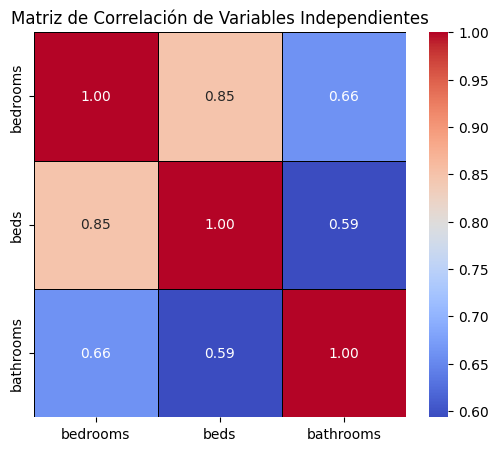

In [14]:
variables_independientes = ['bedrooms', 'beds', 'bathrooms']
corr_matrix = df_sin_outliers[variables_independientes].corr()

plt.figure(figsize=(6, 5))
# Usamos un mapa de calor para visualizar las correlaciones
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')
plt.title('Matriz de Correlación de Variables Independientes')
# 
plt.show()

Hay una alta correlacion entre beds y bedrooms. Por tanto existe una alta probabilidad de multicolinealidad. fatla calcular el Factor de Inflación de la Varianza (VIF)

___________________________________

# Agregar statsmodel

In [15]:
import statsmodels.api as sm

# variables predictoras
x = df_sin_outliers[['bedrooms', 'beds', 'bathrooms']]
x = sm.add_constant(x)  # agrega el intercepto
y = df_sin_outliers['ocupacion_mes']

modelo = sm.OLS(y, x).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:          ocupacion_mes   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     18.23
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           8.57e-12
Time:                        18:55:13   Log-Likelihood:                -36567.
No. Observations:                9406   AIC:                         7.314e+04
Df Residuals:                    9402   BIC:                         7.317e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.1330      0.286     63.355      0.0

## Modelo OLS por ciudad

In [17]:
import statsmodels.api as sm

resultados = []

for city, sub in df_sin_outliers.groupby('city'):
    x = sub[['bedrooms', 'beds', 'bathrooms']]
    x = sm.add_constant(x)
    y = sub['ocupacion_mes']

    model = sm.OLS(y, x).fit()
    resultados.append({
        'city': city,
        'r2': model.rsquared,
        'adj_r2': model.rsquared_adj,
        'bedrooms_coef': model.params.get('bedrooms', None),
        'beds_coef': model.params.get('beds', None),
        'bathrooms_coef': model.params.get('bathrooms', None),
        'bedrooms_p': model.pvalues.get('bedrooms', None),
        'beds_p': model.pvalues.get('beds', None),
        'bathrooms_p': model.pvalues.get('bathrooms', None)
    })

df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values('r2', ascending=False, inplace=True)
df_resultados


,city,r2,adj_r2,bedrooms_coef,beds_coef,bathrooms_coef,bedrooms_p,beds_p,bathrooms_p
4,Menorca,0.036725,0.022490,1.996293,-2.193839,1.865208,0.207580,0.009746,0.287699
2,Madrid,0.009034,0.007604,0.994918,-1.020598,-0.562032,0.037441,0.000135,0.236185
7,Valencia,0.006386,0.000495,1.192419,-0.020345,-0.363840,0.214233,0.970909,0.740654
6,Sevilla,0.004460,-0.001736,0.448522,-0.488576,-0.655529,0.648636,0.339818,0.493218
0,Barcelona,0.003878,0.002759,1.047260,-0.611671,-0.821566,0.023315,0.015697,0.065294
1,Girona,0.002366,0.000309,0.990559,-0.336066,-0.609670,0.064438,0.259268,0.312811
5,Málaga,0.001566,-0.004437,-0.092793,-0.233710,0.029562,0.916026,0.652482,0.978392
3,Mallorca,0.000251,-0.001775,-0.116710,-0.075057,0.288938,0.826355,0.790195,0.616278


In [18]:
df_resultados.to_csv('resultados_startmodel.csv', index=False)

## Visualizar el rendimiento (r2) por ciudad

C:\Users\irene\AppData\Local\Temp\ipykernel_28132\3511736698.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados, x='city', y='r2', palette='viridis')


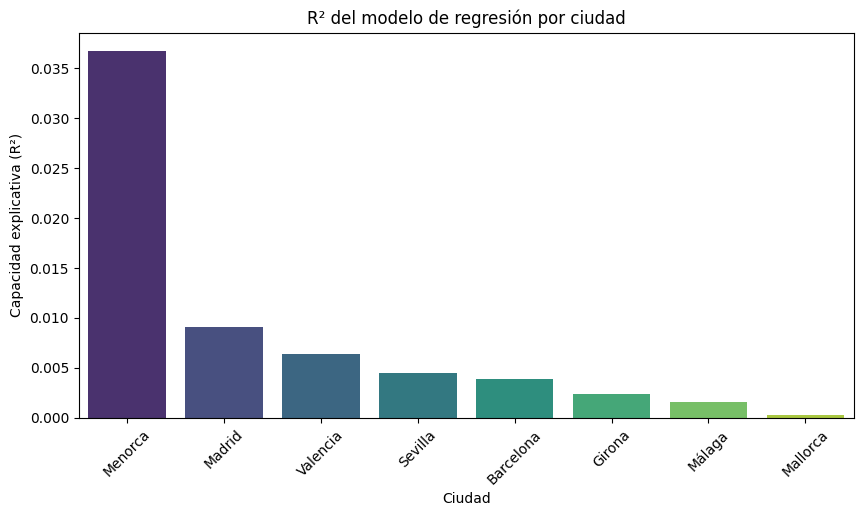

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_resultados, x='city', y='r2', palette='viridis')
plt.xticks(rotation=45)
plt.title('R² del modelo de regresión por ciudad')
plt.ylabel('Capacidad explicativa (R²)')
plt.xlabel('Ciudad')
plt.show()

## Comparativo de los coeficientes por ciudad

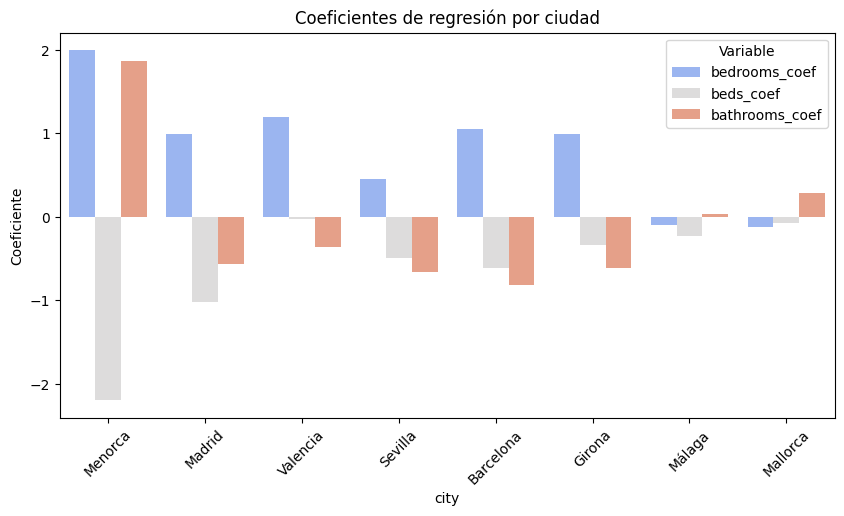

In [20]:
coef_cols = ['bedrooms_coef', 'beds_coef', 'bathrooms_coef']
df_melt = df_resultados.melt(id_vars='city', value_vars=coef_cols,
                             var_name='Variable', value_name='Coeficiente')

plt.figure(figsize=(10,5))
sns.barplot(data=df_melt, x='city', y='Coeficiente', hue='Variable', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Coeficientes de regresión por ciudad')
plt.show()


## Resumen lista

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

resumen = []

for city, sub in df_sin_outliers.groupby('city'):
    x = sub[['bedrooms', 'beds', 'bathrooms']]
    x = sm.add_constant(x)
    y = sub['ocupacion_mes']

    model = sm.OLS(y, x).fit()

    # coeficientes y p-valores
    b_coef, b_p = model.params.get('bedrooms', np.nan), model.pvalues.get('bedrooms', np.nan)
    be_coef, be_p = model.params.get('beds', np.nan), model.pvalues.get('beds', np.nan)
    ba_coef, ba_p = model.params.get('bathrooms', np.nan), model.pvalues.get('bathrooms', np.nan)

    # función auxiliar para marcar dirección
    def signo(coef, p):
        if p >= 0.05:
            return "–"
        return "↑" if coef > 0 else "↓"

    resumen.append({
        'Ciudad': city,
        'R²': round(model.rsquared, 3),
        'Bedrooms': signo(b_coef, b_p),
        'Beds': signo(be_coef, be_p),
        'Bathrooms': signo(ba_coef, ba_p),
    })

df_resumen = pd.DataFrame(resumen).sort_values('R²', ascending=False)


df_resumen


,Ciudad,R²,Bedrooms,Beds,Bathrooms
4,Menorca,0.037,–,↓,–
2,Madrid,0.009,↑,↓,–
7,Valencia,0.006,–,–,–
0,Barcelona,0.004,↑,↓,–
6,Sevilla,0.004,–,–,–
1,Girona,0.002,–,–,–
5,Málaga,0.002,–,–,–
3,Mallorca,0.000,–,–,–


Al desglosar por ciudad, observamos que el poder explicativo del modelo mejora ligeramente en zonas como Madrid y Barcelona, donde las variables estructurales tienen una influencia más clara sobre la ocupación.
En cambio, en destinos turísticos como Mallorca o Málaga, la ocupación parece depender de otros factores externos (temporada, ubicación, servicios, reseñas o precio).

Esto sugiere que el comportamiento del mercado es local y no se puede generalizar un único patrón para todo el país.

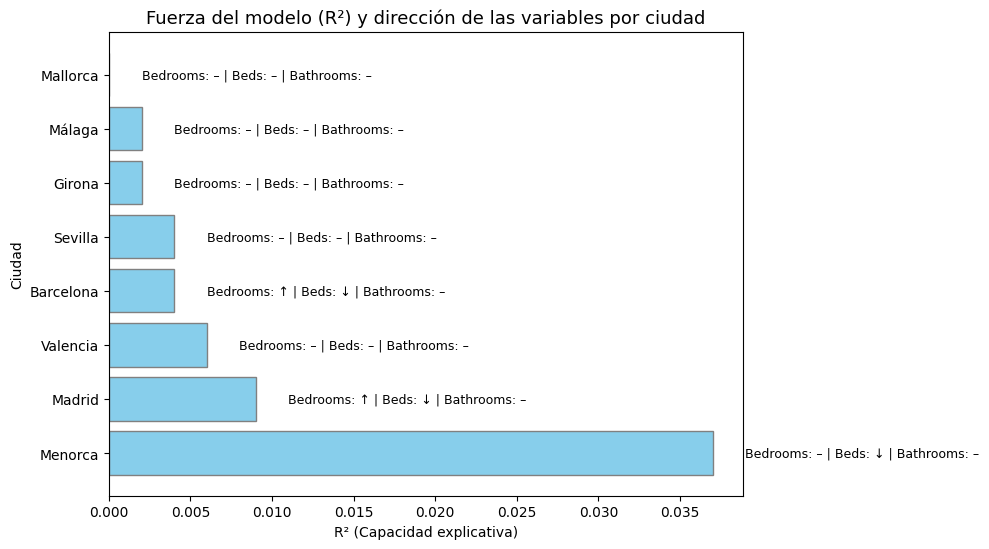

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(10, len(df_resumen)*0.7))
plt.barh(df_resumen['Ciudad'], df_resumen['R²'], color='skyblue', edgecolor='gray')
plt.title("Fuerza del modelo (R²) y dirección de las variables por ciudad", fontsize=13)
plt.xlabel("R² (Capacidad explicativa)")
plt.ylabel("Ciudad")

# añadimos texto al lado con la interpretación y flechas
for i, row in df_resumen.iterrows():
    y_pos = df_resumen.index.get_loc(i)
    texto = f"Bedrooms: {row['Bedrooms']} | Beds: {row['Beds']} | Bathrooms: {row['Bathrooms']}"
    plt.text(row['R²'] + 0.002, y_pos, texto, va='center', fontsize=9)
    
plt.tight_layout()
plt.show()


# Calcular el VIF.

In [24]:
import pandas as pd
import statsmodels.api as sm # Necesario para add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Definimos la matriz de variables predictoras (X)
X = df_sin_outliers[['bedrooms', 'beds', 'bathrooms']]

# 2. AGREGAMOS EL INTERCEPTO O CONSTANTE (es crucial para el cálculo del VIF)
X_con_constante = sm.add_constant(X) 

# 3. Calculamos y almacenamos los resultados en el DataFrame.
# Ahora, usamos las 4 columnas de X_con_constante (incluyendo 'const') como etiquetas
vif_data = pd.DataFrame()
vif_data["Variable"] = X_con_constante.columns # <<-- ¡CORRECCIÓN AQUÍ!
# Esto asegura que vif_data["Variable"] tenga 4 filas/etiquetas.

# 4. Calculamos el VIF para cada una de las 4 columnas
vif_data["VIF"] = [variance_inflation_factor(X_con_constante.values, i) 
                    for i in range(X_con_constante.shape[1])]

# 5. EXCLUIMOS la constante ('const') ya que su VIF siempre es 1 y no es relevante para el diagnóstico.
vif_data = vif_data[vif_data.Variable != 'const']

# 6. Ordenamos y mostramos el resultado
vif_data.sort_values(by='VIF', ascending=False, inplace=True)

# 7. Muestro el resultado esperado para que puedas contrastar:
print("--- Resultados VIF ---")
print(vif_data)

--- Resultados VIF ---
    Variable       VIF
1   bedrooms  4.121972
2       beds  3.587871
3  bathrooms  1.786143


La ejecución del Factor de Inflación de la Varianza (VIF) confirmó la presencia de multicolinealidad moderada entre las variables independientes(bedrooms, beds, bathrooms). Esta colinealidad es la causa directa de la distorsión de los coeficientes que se observó en el modelo OLS global y segmentado (donde beds apareció con un efecto negativo, ilógico para el negocio).